# shape systematics

In order to assess the effect of various shape systematics, I will take the approach of identifying the sources of such uncertainties and then characterize how much the various distributions that are fitted are affected.  This approach will be based on the prescriptions put forth by Conway (arXiv:1103.0354).  The basic idea is to vary parameter $\theta$ within its prior uncertainty, $\sigma_{\theta}$, and derive modifications to the efficiency in bin $i$.  That is, given some nominal efficiency, $\epsilon^{0}_{ij}$, for process $j$, we find $\epsilon^{\pm}_{ij}$ and then parameterize the bin content as,

$$
\epsilon_{ij} = \epsilon^{0}_{ij} + f\frac{\epsilon^{+}_{ij} + \epsilon^{-}_{ij}}{2}.
$$

This expression gives us a linear approximation of the effect of varying the nuisance parameter.  A quadratic construction is,

$$
\epsilon_{ij} = \frac{f(f - 1)}{2}\epsilon^{-}_{ij} + (f - 1)(f + 1)\epsilon^{0}_{ij} + \frac{f(f + 1)}{2}\epsilon^{+}_{ij}.
$$

Conway suggests using the quadratic form for $|f| < 1$ and then using the linear expression for $|f| \geq 1$. The important, part is that we determine what $\epsilon^{\pm}_{ij}$ are.  We will first consider the effect of uncertainty on weighting of events due to pileup.

In [1]:
# imports and configuration
%cd /home/naodell/work/wbr/analysis

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

import scripts.plot_tools as pt
import scripts.systematic_tools as st
import scripts.fit_helpers as fh
pt.set_default_style()

/home/naodell/work/wbr/analysis
Welcome to JupyROOT 6.14/04


In [16]:
# Get the data (unbinned)
### get the data and prepare labels
datasets    = ['ttbar_inclusive', 't_tw', 'tbar_tw',             
               #'zjets_m-50',  'zjets_m-10to50',  
               ] 

selection = 'etau'
dm = pt.DataManager(input_dir     = f'local_data/flatuples/test/{selection}_2016',
                    dataset_names = datasets,
                    selection     = selection,
                    period        = 2016,
                    scale         = 35.9e3,
                    cuts          = pt.cuts[selection]
                   )

feature = fh.features[selection]
brange = (20, 160)
nbins = 50

Loading dataframes: 100%|███████████████| 3.00/3.00 [00:03<00:00, 2.69s/it]


## pileup

Pileup should not be expected to make too significant of an impact on the distributions used in the parameter extractions (mostly lepton kinematic quantities) or the overall yield.  It serves as a good test ground for this technique since the variation of the weights has a [well prescribed procedure](https://twiki.cern.ch/twiki/bin/view/CMS/PileupJSONFileforData).  For reference, this is the pileup weight distribution for the nominal and $\pm \sigma$ scenarios.

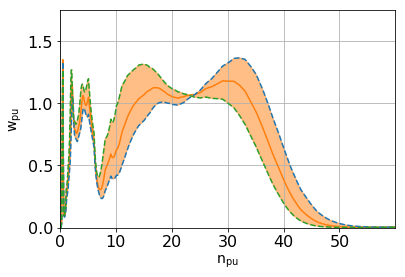

In [3]:
# Get the scale factors
from scipy.interpolate import interp1d

# the scale factors will be into interp1d objects so they can be evaluated continuously
pileup_file = open('data/pileup_sf.pkl', 'rb')
bins = pickle.load(pileup_file)
sf_nominal = interp1d(bins, pickle.load(pileup_file), kind='linear')
sf_up = interp1d(bins, pickle.load(pileup_file), kind='linear')
sf_down = interp1d(bins, pickle.load(pileup_file), kind='linear')

# make sure they look reasonable
fig, ax = plt.subplots(1, 1, figsize=(6, 4), facecolor='white')
ax.plot(bins, sf_nominal(bins), c='C1')                            
ax.fill_between(bins, sf_up(bins), sf_down(bins), color='C1', alpha=0.5,)
ax.plot(bins, sf_up(bins), c='C0', linestyle='--')                 
ax.plot(bins, sf_down(bins), c='C2', linestyle='--')               
ax.set_xlim(0, 59.9)                                          
ax.set_ylim(0, 1.75)                                          
ax.set_xlabel(r'$\sf n_{pu}$', fontsize=14)                   
ax.set_ylabel(r'$\sf w_{pu}$', fontsize=14)                   
ax.grid()                                                     

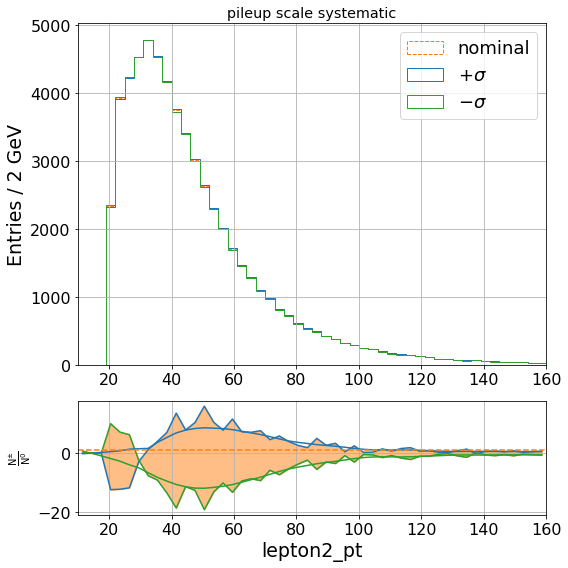

In [7]:
# weight the data according to the three pileup scenarios
df = dm.get_dataframe('ttbar')
df = df.query(f'n_pu > {bins.min()} and n_pu < {bins.max()}')

fig, axes = plt.subplots(2, 1, figsize=(8, 8), facecolor='white', sharex=False, gridspec_kw={'height_ratios':[3,1]})
fig.subplots_adjust(hspace=0)

ax = axes[0]
h_nominal, b, _ = ax.hist(df[feature], range=brange, bins=nbins, color='C1', linestyle='--', histtype='step', weights=df.weight)
h_plus, _, _    = ax.hist(df[feature], range=brange, bins=nbins, color='C0', histtype='step', weights=(df.weight/sf_nominal(df.n_pu))*sf_up(df.n_pu))
h_minus, _, _   = ax.hist(df[feature], range=brange, bins=nbins, color='C2', histtype='step', weights=(df.weight/sf_nominal(df.n_pu))*sf_down(df.n_pu))

h_err, _ = np.histogram(df.lepton2_pt, bins=nbins, range=brange, weights=df.weight**2)

dx = (b[1:] - b[:-1])/2
x = b[:-1] + dx

ax.legend(['nominal', r'$+\sigma$', r'$-\sigma$'])
ax.set_xlim(brange)
ax.set_ylabel('Entries / 2 GeV')
ax.set_title('pileup scale systematic')
ax.grid()

ax = axes[1]
y_up = h_plus - h_nominal
y_down = h_minus - h_nominal

# experimental smoothing
y_up_smooth = lowess(y_up, x, frac=0.2, it=10).T[1]
y_down_smooth = lowess(y_down, x, frac=0.2, it=10).T[1]
########################

ax.plot(x, y_up, 'C0')
ax.plot(x, y_down, 'C2')
ax.plot(x, y_up_smooth, 'C0')
ax.plot(x, y_down_smooth, 'C2')

ax.fill_between(x, y_up, y_down, color = 'C1', alpha=0.5)
ax.plot(brange, [1, 1], 'C1--')

ax.set_xlim(brange)
#ax.set_ylim(0.98, 1.02)
ax.set_xlabel(feature)
ax.set_ylabel(r'$\sf \frac{N^{\pm}}{N^{0}}$', fontsize=14)
ax.grid()
#ax.set_yscale('linear')

plt.tight_layout()
plt.show()

# lepton pt scale

The muon $p_{T}$ is corrected using the Rochester muon momentum corrections.  I'm still searching for the official recommendation so for now I'll use the values quoted in SMP-16-013 (inclusive W/Z cross-section measurement) which have values of 0.1-0.2% for the muon scale uncertainty.  To do this properly, it will need to be done before the pt thresholds are applied since there will be some migration of events across the cut boundary.

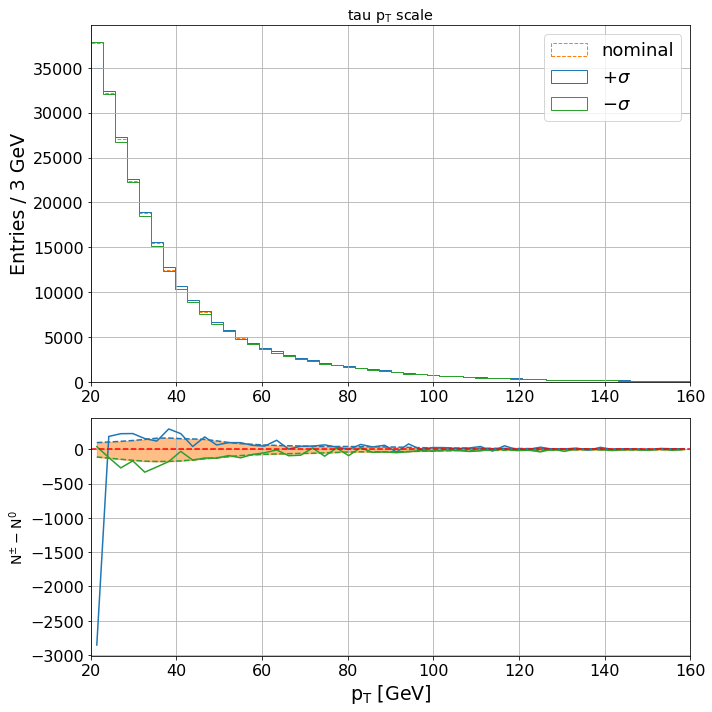

In [20]:
# weight the data according to the three pileup scenarios
df = dm.get_dataframe('ttbar')

fig, axes = plt.subplots(2, 1, figsize=(10, 10), facecolor='white', sharex=False, gridspec_kw={'height_ratios':[3,2]})
fig.subplots_adjust(hspace=0)

ax = axes[0]
h_nominal, b, _ = ax.hist(df.lepton2_pt, range=brange, bins=nbins, color='C1', linestyle='--', histtype='step')
h_plus, _, _ = ax.hist(1.01*df.lepton2_pt, range=brange, bins=nbins, color='C0', histtype='step')
h_minus, _, _ = ax.hist(0.99*df.lepton2_pt, range=brange, bins=nbins, color='C2', histtype='step')
ax.legend(['nominal', r'$+\sigma$', r'$-\sigma$'])
ax.set_xlim(brange)
ax.set_ylabel('Entries / 3 GeV')
if selection in ['mumu', 'emu', 'mu4j']:
    ax.set_title(r'muon $\sf p_{T}$ scale')
elif selection in ['ee', 'emu', 'e4j']:
    ax.set_title(r'electron $\sf p_{T}$ scale')
elif selection in ['etau', 'mutau']:
    ax.set_title(r'tau $\sf p_{T}$ scale')
ax.grid()

ax = axes[1]
dx = (b[1:] - b[:-1])/2
x = b[:-1] + dx
y_up = h_plus - h_nominal
y_down = h_minus - h_nominal

# experimental smoothing
y_up_smooth = lowess(y_up, x, frac=0.2, it=1).T[1]
y_down_smooth = lowess(y_down, x, frac=0.2, it=1).T[1]
########################

ax.plot(x, y_up, 'C0')
ax.plot(x, y_down, 'C2')
ax.plot(x, y_up_smooth, 'C0--')
ax.plot(x, y_down_smooth, 'C2--')
ax.fill_between(x, y_up_smooth, y_down_smooth, color = 'C1', alpha=0.5)
ax.plot(brange, [0, 0], 'r--')

ax.set_xlim(brange)
#ax.set_ylim(-3, 3)
ax.set_xlabel(r'$\sf p_{T}$ [GeV]')
ax.set_ylabel(r'$\sf N^{\pm} - N^{0}$', fontsize=14)
ax.grid()
#ax.set_yscale('linear')

plt.savefig(f'plots/systematics/{selection}_lepton_pt_scale.pdf')
plt.tight_layout()
plt.show()